# Exercise 5: Sinusoidal model


### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp.

__Sinusoidal modeling and sine tracking:__
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking.

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time.
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies.

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid.

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` estimates the frequency of a sinusoidal signal at a given time instant. The function  returns the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function returns a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file is a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size is chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size is the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`.

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [1]:
import numpy as np
from scipy.signal import get_window
import math
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from smstools.models import sineModel as SM
import IPython.display as ipd


In [2]:
import numpy as np
from scipy.signal import get_window
import math
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from smstools.models import sineModel as SM
import IPython.display as ipd

def min_freq_est_err(input_file, f):
    """Estimate the frequency of a sinusoidal signal by iterating over different sizes of analysis window"""
    
    # Read the input wav file
    fs, signal = UF.wavread(input_file)  # Assuming UF has a function to read the wav file
    print(fs)
    # Length of signal
    signal_length = len(signal)
    
    # Define window sizes: we only need to check M = 100*k + 1
    M_list = []
    k = 1
    while True:
        M = 100 * k + 1
        if M > signal_length:
            break
        M_list.append(M)
        k += 1

    # Define threshold for peak detection (in dB)
    t = -40

    # Iterate over different window sizes and compute frequency estimation
    for M in M_list:
        N = 2 ** np.ceil(np.log2(M))  # FFT size (next power of 2)
        
        # Define the center of the window (around 0.5 seconds)
        center_index = int(0.5 * fs)
        start_idx = center_index - M // 2
        end_idx = start_idx + M
        
        # Extract a fragment of the signal for analysis
        x = signal[start_idx:end_idx]
        
        # Apply the Blackman window
        window = get_window('blackman', M)
        
        # Perform the DFT
        X,p= DFT.dftAnal(x, window, int(N))  # Pass the window as the second argument
     
        # Detect peaks in the DFT
        peaks = UF.peakDetection(X, t)
        
        
        # If there are no peaks detected, skip to next M
        if len(peaks) == 0:
            print(f"No peaks detected for M = {M}")
            continue
        
        # Interpolate the peak for a better frequency estimate
        loc,_,_ = UF.peakInterp(X,p, peaks)
        
        f_est = loc * fs / N
        
        # Calculate the frequency estimation error
        freq_error = abs(f - f_est)
        
        
        # If the error is less than 0.05 Hz, return the results
        if freq_error < 0.05:
            return f_est, M, int(N)

    # If no suitable M found (very unlikely), return None
    print("No suitable window size found")
    return None
    

    # If no suitable M found (very unlikely), return None
    print("No suitable window size found")
    return None


In [3]:
def generate_sin_wave(f, fs, duration=2):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    signal = np.sin(2 * np.pi * f * t)
    return signal

In [ ]:


print('Test case 1: ')
UF.wavplay('sine-490.wav')
f_est, M, N= min_freq_est_err('sine-490.wav', 490.0)
print('M:', M, 'N:', N, 'frequency estimation:', f_est)

fs = 44100  # Sampling frequency (same as in the input signal)
generated_signal = generate_sin_wave(f_est, fs)

UF.wavwrite(generated_signal, fs, 'estimated_sine_490.wav')
UF.wavplay('estimated_sine_490.wav')

Test case 1: 
44100
M: 1101 N: 2048 frequency estimation: [489.9630183]


In [5]:
print('Test case 2: ')
UF.wavplay('sine-1000.wav')
f_est, M, N= min_freq_est_err('sine-1000.wav', 1000.0)
print('M:', M, 'N:', N, 'frequency estimation:', f_est)

fs = 44100  # Sampling frequency (same as in the input signal)
generated_signal = generate_sin_wave(f_est, fs)

UF.wavwrite(generated_signal, fs, 'estimated_sine_1000.wav')
UF.wavplay('estimated_sine_1000.wav')

Test case 2: 
44100
M: 1101 N: 2048 frequency estimation: [1000.01994268]


In [6]:
print('Test case 3: ')
UF.wavplay('sine-200.wav')
f_est, M, N= min_freq_est_err('sine-200.wav', 200.0)
print('M:', M, 'N:', N, 'frequency estimation:', f_est)

fs = 44100  # Sampling frequency (same as in the input signal)
generated_signal = generate_sin_wave(f_est, fs)

UF.wavwrite(generated_signal, fs, 'estimated_sine_200.wav')
UF.wavplay('estimated_sine_200.wav')

Test case 3: 
44100
M: 1201 N: 2048 frequency estimation: [200.03811968]



------
Our frequency estimation is very accurate, with a maximum error of only 0.05 Hz. This small discrepancy is negligible and is not perceptible to the human ear, as it falls well within the threshold of auditory discrimination.

## Part 2 - Tracking a two component chirp

We perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`.

We use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies  results in a mean error smaller than 2Hz.

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`.

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram.

In [7]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given signal length and sampling rate.

    Args:
        xlen (int): duration of signal in samples
        M (int): window size
        fs (int): sampling rate
        H (int): hop size

    Result:
        np.array: time stamps

    """
    hM1 = int(np.floor((M+1)/2))
    hM2 = int(np.floor(M/2))
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound

    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples

   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component

    """

    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation

    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)

    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M`  is chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks are done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values.



Window size: 512, Mean error: [270.19672751 433.72598394]
Window size: 1023, Mean error: [ 13.66932655 528.5333854 ]
Window size: 2046, Mean error: [  7.02600379 454.97532325]
Window size: 3069, Mean error: [ 1.19074945 13.35519703]
Window size: 6138, Mean error: [11.06651505 23.02265918]


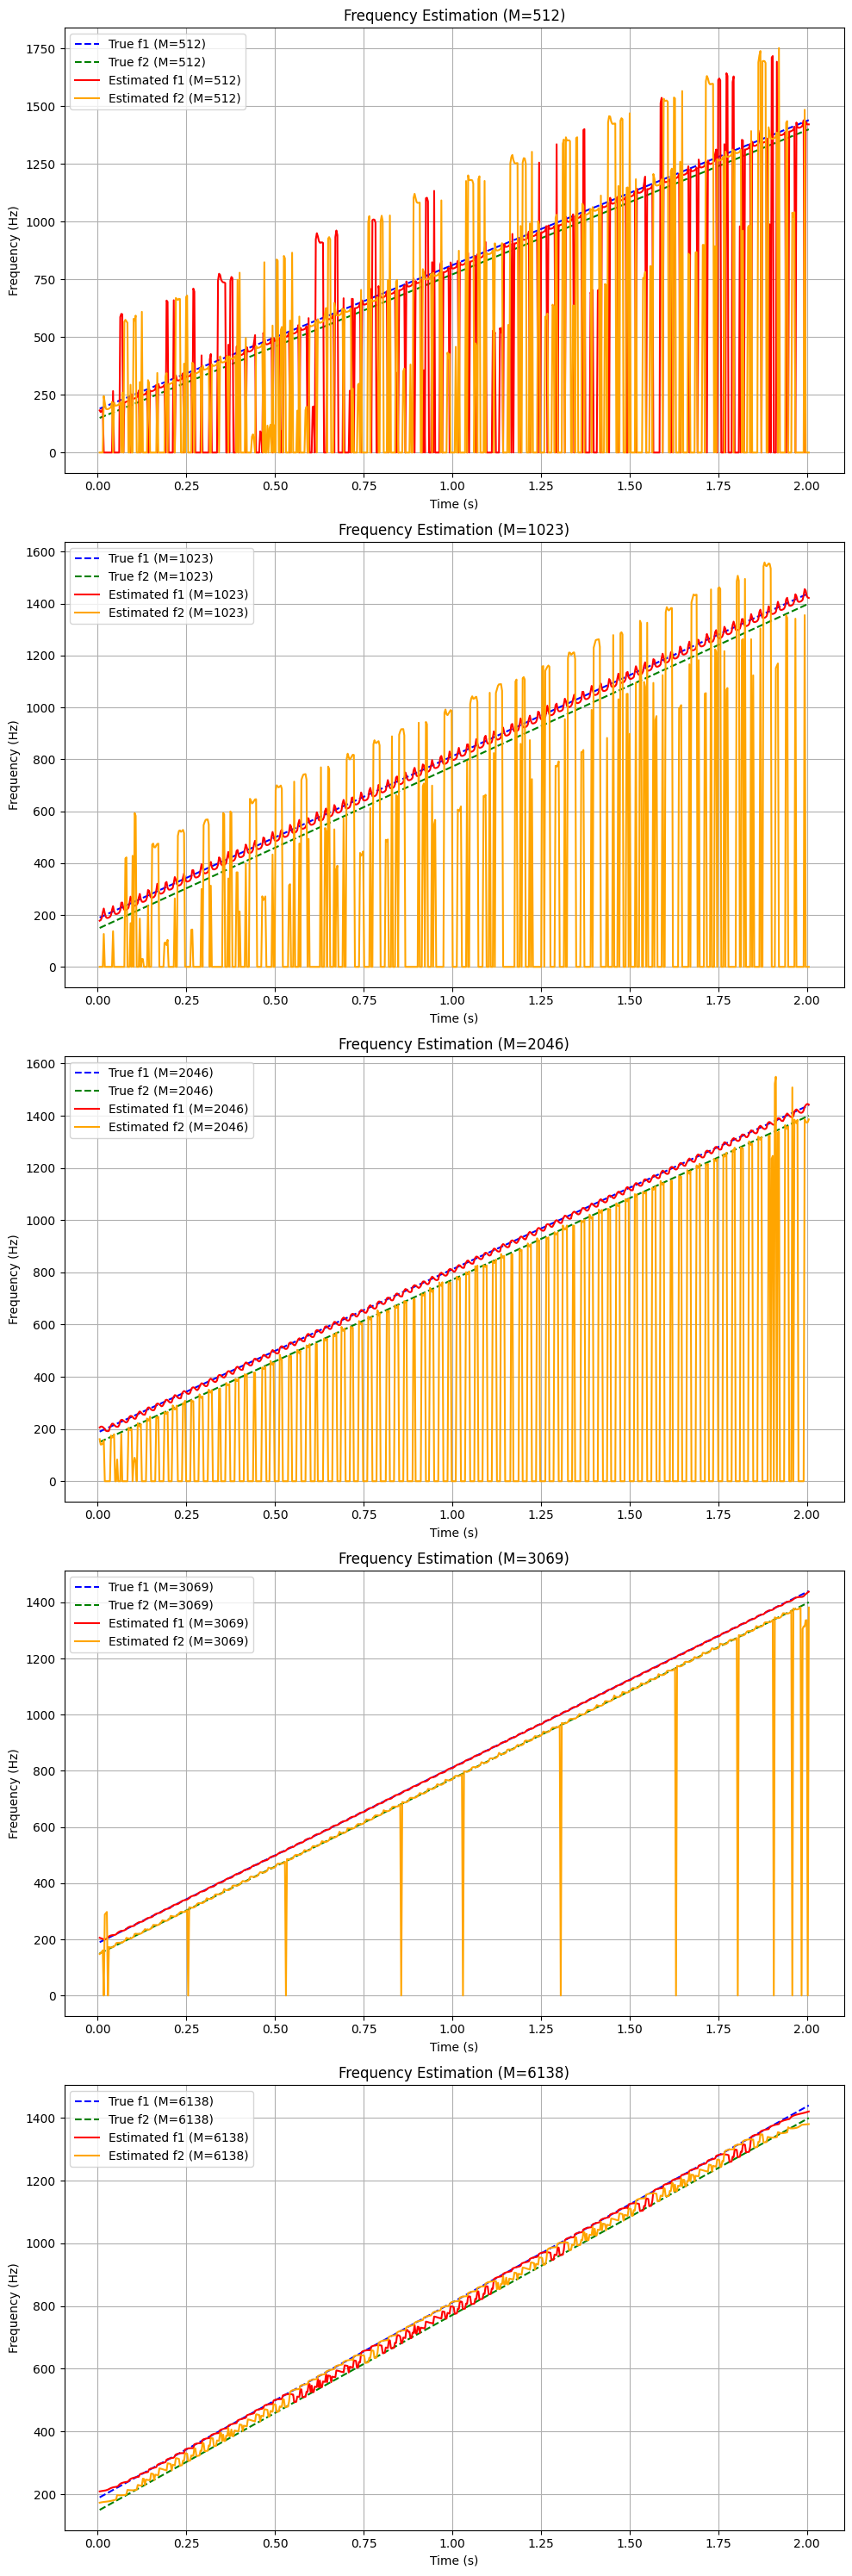

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from smstools.models import sineModel as SM



# Function to call freq_tracker_error and plot results
def plot_frequency_tracking(input_file, window, H, t, M_values):
    # Read the sound file
    fs, x = UF.wavread(input_file)
    tStamps = gen_time_stamps(x.size, M_values[0], fs, H)  # Generate time stamps for the first M value
    fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)  # Get true frequency tracks

    num_plots = len(M_values)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))  # One graph per window size

    for i, M in enumerate(M_values):
        # Call the freq_tracker_error function
        meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
        
        # Plot the true vs estimated frequencies for both components (f1 and f2) in the same graph
        ax = axes[i]
        ax.plot(tStamps, fTrackTrue[:, 0], label=f'True f1 (M={M})', linestyle='--', color='b')
        ax.plot(tStamps, fTrackTrue[:, 1], label=f'True f2 (M={M})', linestyle='--', color='g')
        ax.plot(tStamps, fTrackEst[:, 0], label=f'Estimated f1 (M={M})', color='r')
        ax.plot(tStamps, fTrackEst[:, 1], label=f'Estimated f2 (M={M})', color='orange')

        ax.set_title(f'Frequency Estimation (M={M})')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.grid(True)
        ax.legend()

        # Print the mean error for this window size
        print(f"Window size: {M}, Mean error: {meanErr}")

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# Parameters
H = 128  # Hop size
window = 'blackman'  # Window type
t = -80  # Threshold for peak picking (negative dB)
input_file = 'chirp-150-190-linear.wav'  # Input file path
M_values = [512, 1023, 2046, 3069, 6138]  # Different window sizes to test

# Call the function to plot the results
plot_frequency_tracking(input_file, window, H, t, M_values)




Larger window sizes improve frequency estimation accuracy by providing better frequency resolution.
Smaller windows introduce more noise and estimation errors due to spectral leakage and lower resolution.
Choosing an appropriate window size is crucial: while a larger M improves accuracy, it also increases computational cost and may reduce temporal resolution. The optimal window size is likely 3069, as it balances frequency estimation accuracy and computational cost.

## Part 3 -Tracking sinusoids of different amplitudes

We perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`.

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`.

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`.

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid.

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` is specified in negative dB.



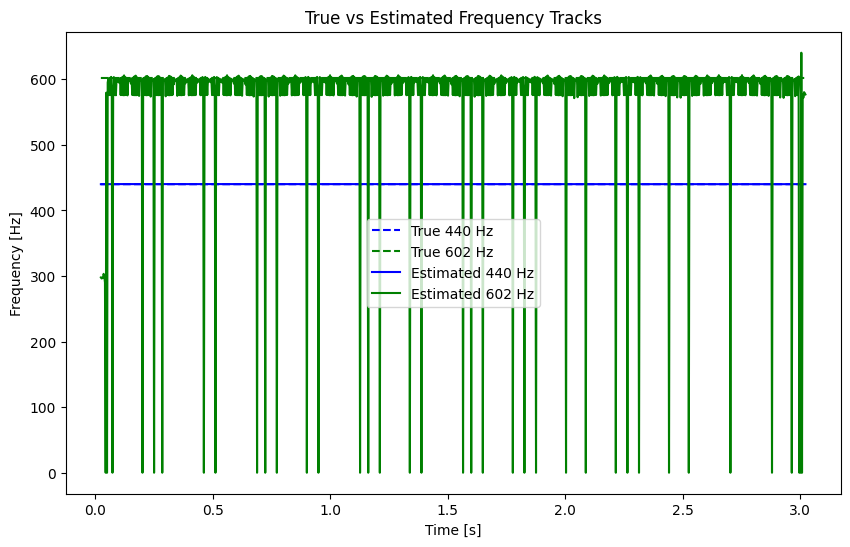

Mean Estimation Errors: [ 0.19603701 29.51140584] Hz


In [ ]:


M = 2047                                             # Window size
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = 'sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

tStamps = gen_time_stamps(x.size, M, fs, H)
# Generate true frequency tracks for the signal
fTrackTrue = gen_true_freq_tracks_440_602(tStamps)

# Test case for window 'hanning' and threshold -80 dB
window = 'hann'
t = -80.0

# Call the freq_tracker_error function with the test case values
err, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

# Plot the true frequency tracks vs estimated frequency tracks
plt.figure(figsize=(10, 6))
plt.plot(tStamps, fTrackTrue[:, 0], label='True 440 Hz', color='blue', linestyle='--')
plt.plot(tStamps, fTrackTrue[:, 1], label='True 602 Hz', color='green', linestyle='--')
plt.plot(tStamps, fTrackEst[:, 0], label='Estimated 440 Hz', color='blue')
plt.plot(tStamps, fTrackEst[:, 1], label='Estimated 602 Hz', color='green')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('True vs Estimated Frequency Tracks')
plt.legend(loc='best')
plt.show()

# Mean estimation errors
print(f"Mean Estimation Errors: {err} Hz")




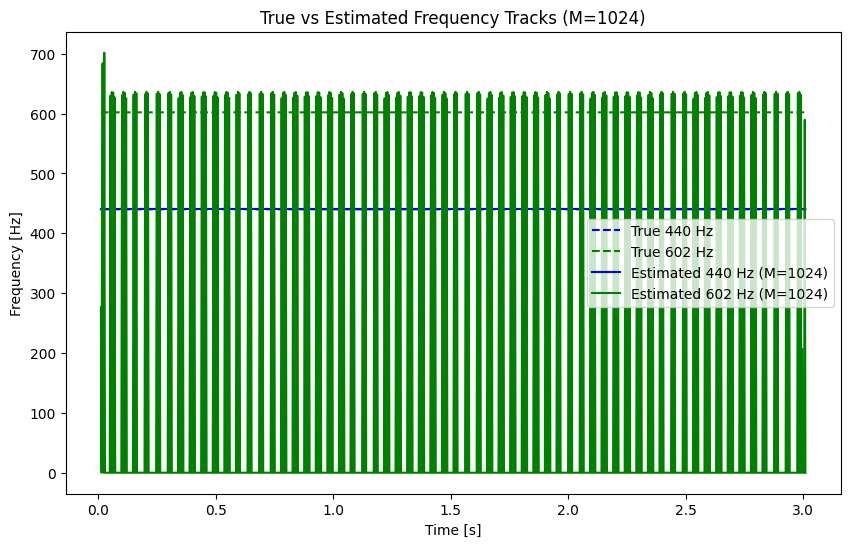

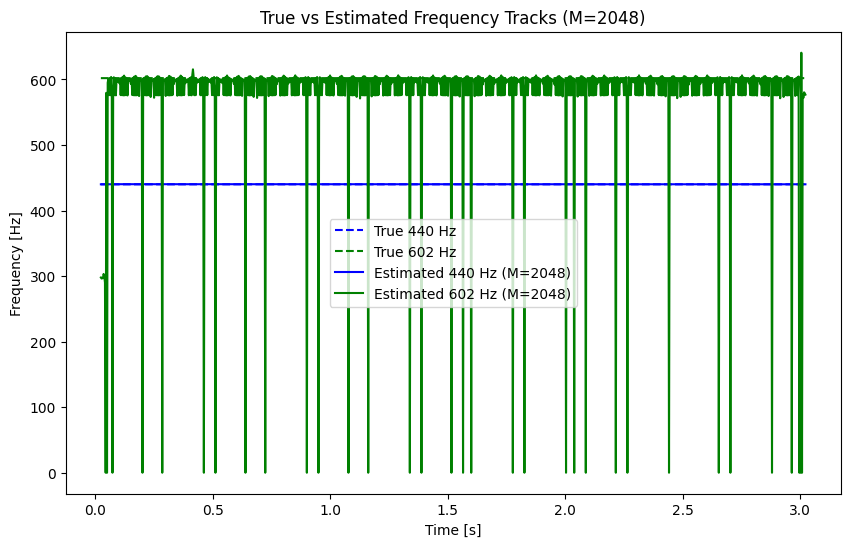

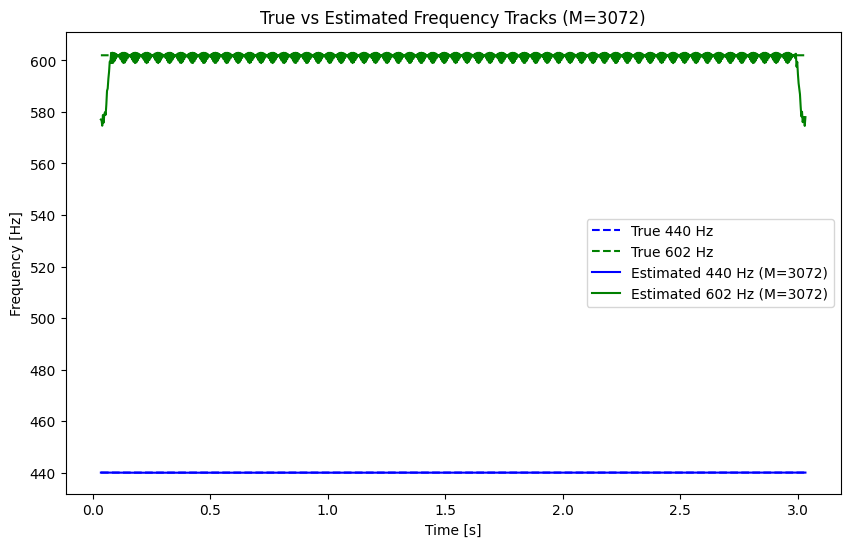

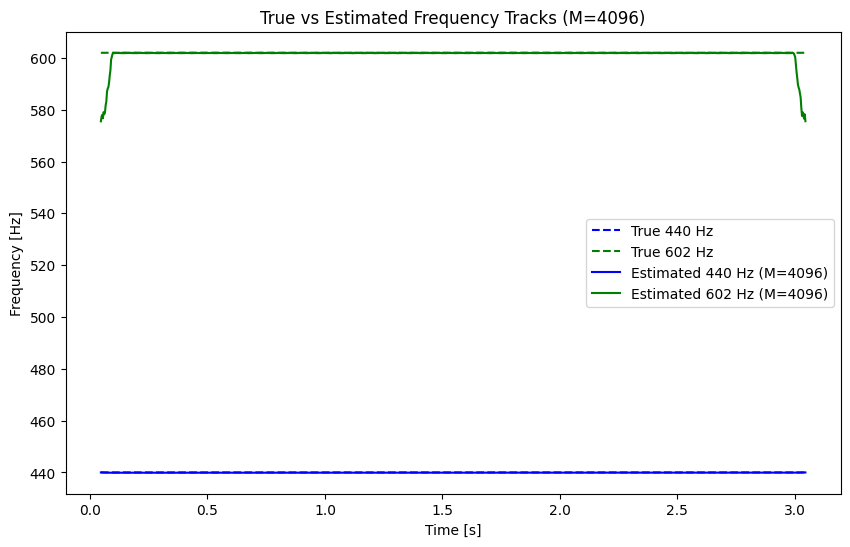

The best M value is:  4096


In [10]:
#Now we try to find the best M value
N = 4096  # FFT Size
H = 128   # Hop size in samples
input_file = 'sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)

# Test different window sizes
M_values = [1024, 2048, 3072, 4096]
errors = []

for M in M_values:
    tStamps = gen_time_stamps(len(x), M, fs, H)
    fTrackTrue = gen_true_freq_tracks_440_602(tStamps)
    window = 'hann'
    threshold = -80.0
    err, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, threshold, H, M)
    errors.append(np.mean(err))
    
    # Plot for each M
    plt.figure(figsize=(10, 6))
    plt.plot(tStamps, fTrackTrue[:, 0], label='True 440 Hz', linestyle='--', color='blue')
    plt.plot(tStamps, fTrackTrue[:, 1], label='True 602 Hz', linestyle='--', color='green')
    plt.plot(tStamps, fTrackEst[:, 0], label=f'Estimated 440 Hz (M={M})', color='blue')
    plt.plot(tStamps, fTrackEst[:, 1], label=f'Estimated 602 Hz (M={M})', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.title(f'True vs Estimated Frequency Tracks (M={M})')
    plt.legend()
    plt.show()

# Find optimal M
best_M = M_values[np.argmin(errors)]
print('The best M value is: ', best_M)

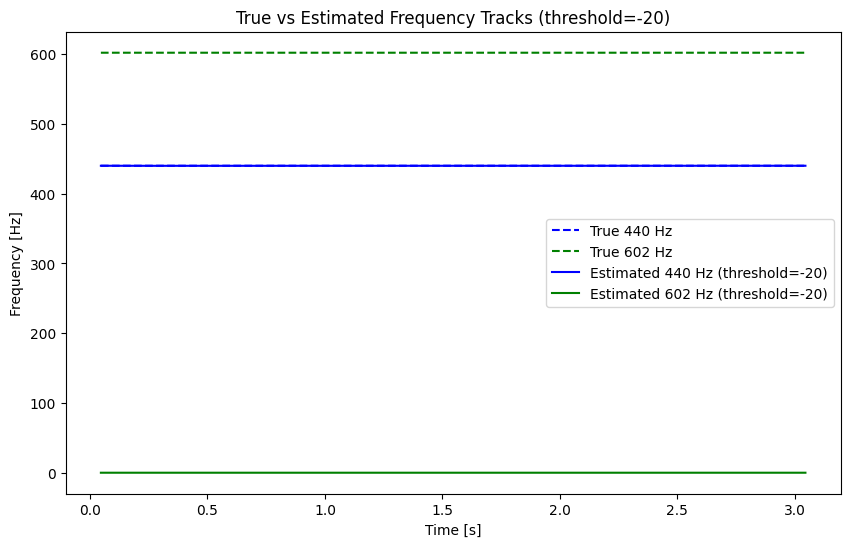

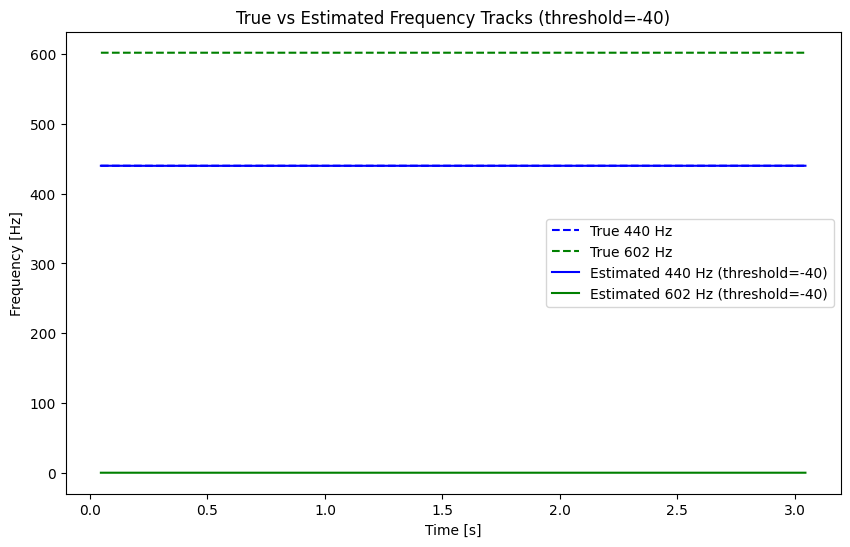

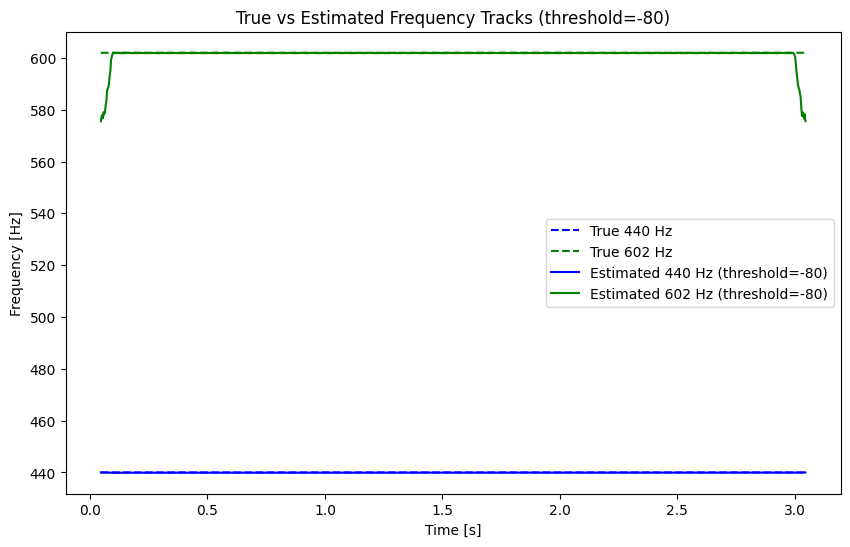

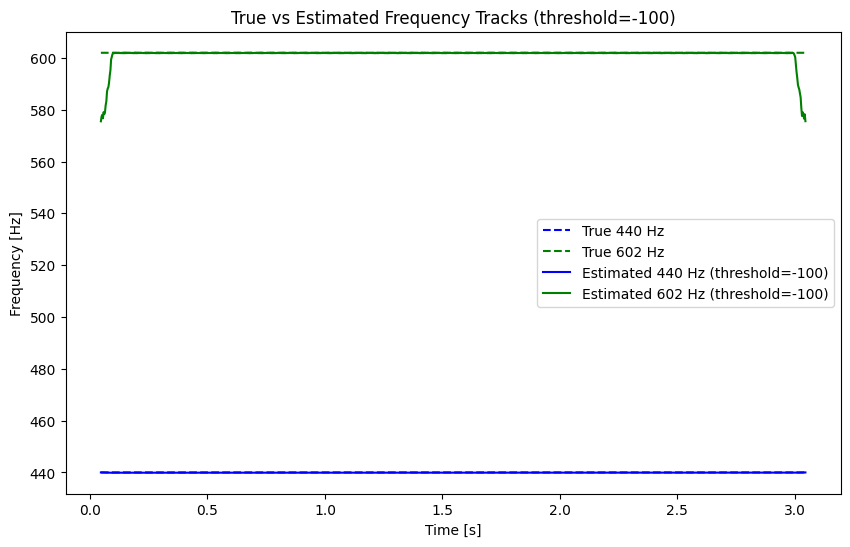

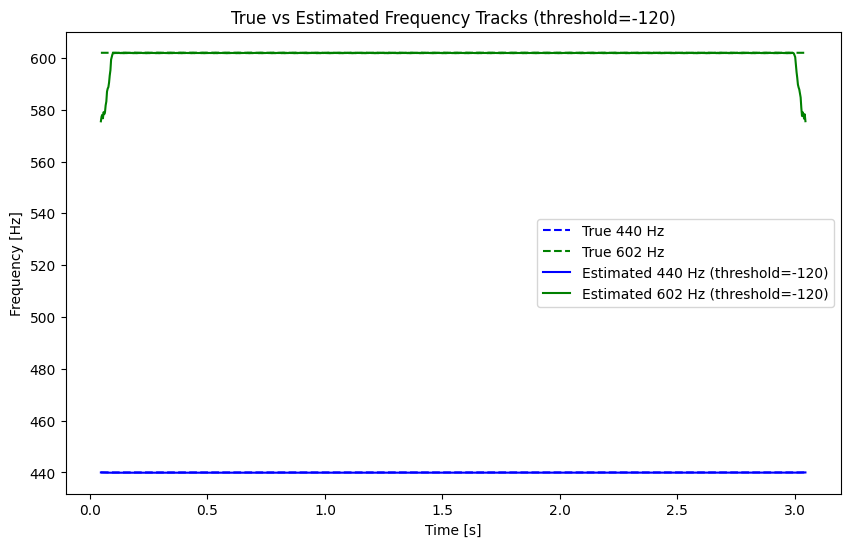

The best threshold value is:  -80


In [11]:
#Now we try to find the best threshold and M value
N = 4096  # FFT Size
H = 128   # Hop size in samples
input_file = 'sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)

# Test different window sizes
threshold_values = [-20, -40, -80, -100, -120]
M = 4096
errors = []

for threshold in threshold_values:
    tStamps = gen_time_stamps(len(x), M, fs, H)
    fTrackTrue = gen_true_freq_tracks_440_602(tStamps)
    window = 'hann'
   
    err, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, threshold, H, M)
    errors.append(np.mean(err))
    
    # Plot for each M
    plt.figure(figsize=(10, 6))
    plt.plot(tStamps, fTrackTrue[:, 0], label='True 440 Hz', linestyle='--', color='blue')
    plt.plot(tStamps, fTrackTrue[:, 1], label='True 602 Hz', linestyle='--', color='green')
    plt.plot(tStamps, fTrackEst[:, 0], label=f'Estimated 440 Hz (threshold={threshold})', color='blue')
    plt.plot(tStamps, fTrackEst[:, 1], label=f'Estimated 602 Hz (threshold={threshold})', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.title(f'True vs Estimated Frequency Tracks (threshold={threshold})')
    plt.legend()
    plt.show()

# Find optimal M
best_threshold = threshold_values[np.argmin(errors)]
print('The best threshold value is: ', best_threshold)



For a small M (1024, 2048), the estimated 602 Hz frequency fluctuates significantly, showing instability and for larger M (3072, 4096), the frequency estimation stabilizes, closely following the true values.
This indicates that a larger window size improves frequency resolution and reduces noise, leading to more accurate frequency tracking.

On the other hand small thresholds (-20, -40) fails to estimate the 602 Hz frequency correctly because it filters out weaker spectral components, leading to missing frequency tracks in the estimation process. When the threshold is -80 dB or bigger (-100 dB), the estimated frequency still has the same error because the estimation process has reached its noise floor, since all relevant frequency peaks are already considered.

## Part 4 - Sinusoidal modeling of a multicomponent signal

We perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found.

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram.



44100


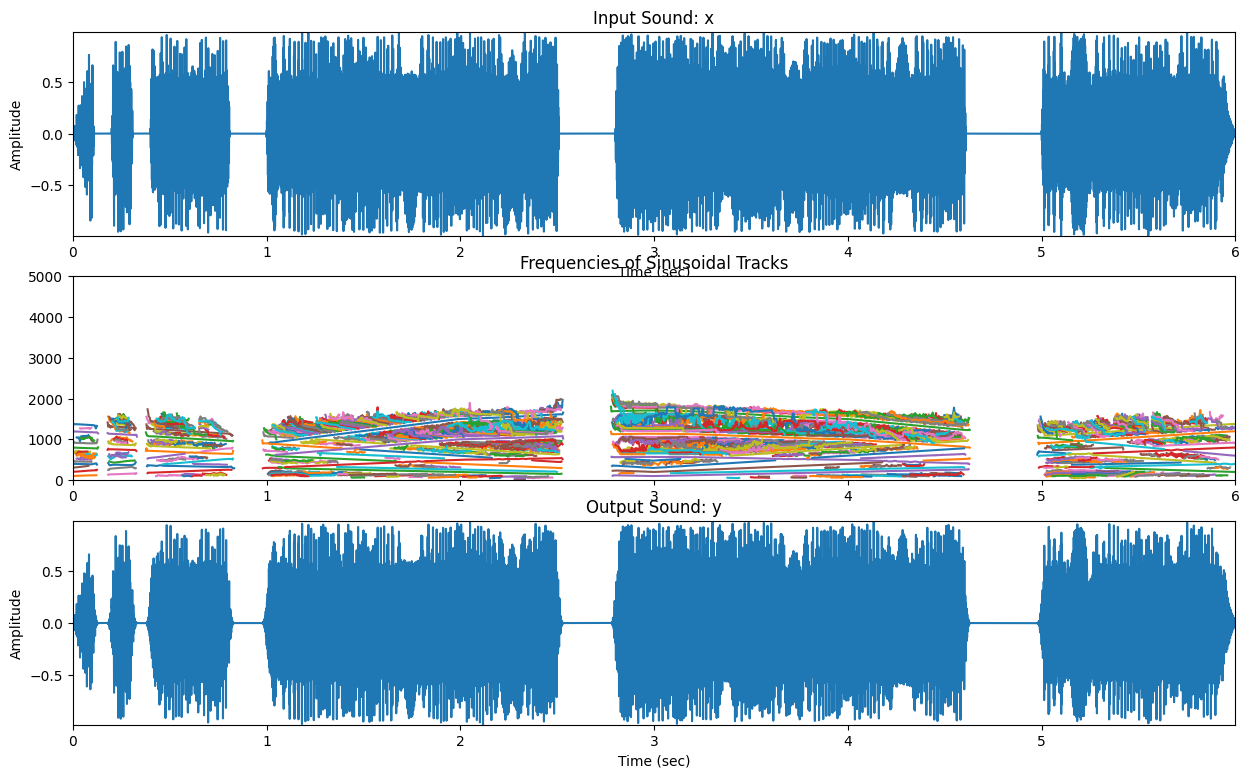

In [16]:
import IPython.display as ipd

input_file = 'multiSines.wav'

window = 'hamming'         # Hamming window for good time-frequency resolution
M = 2248                    # Window length to capture transients and fine details
N = 4096                   # FFT size to resolve close frequencies
t = -80               # Time step (hop size) to capture fine variations
minSineDur = 0.05          # Minimum duration for sinusoids (to avoid overly splitting short tracks)
maxnSines = 40             # Maximum number of sinusoids per frame (to capture all sinusoids)
freqDevOffset = 0.5        # Frequency deviation offset for handling chirps
freqDevSlope = 0.1         # Frequency deviation slope for smooth frequency variations


# No need to modify the code after here
Ns = 512                                      # Size of fft used in synthesis
H = 128                                       # Hop size (has to be 1/4 of Ns)

fs, x = UF.wavread(input_file)
print(fs)                # Read input sound
w = get_window(window, M)                     # Compute analysis window

# Analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# Synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# Create figure to show plots
plt.figure(figsize=(15, 9))

# Frequency range to plot
maxplotfreq = 5000.0

# Plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('Amplitude')
plt.xlabel('Time (sec)')
plt.title('Input Sound: x')

# Plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H * np.arange(numFrames) / float(fs)
    tfreq[tfreq <= 0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('Frequencies of Sinusoidal Tracks')

# Plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)

plt.ylabel('Amplitude')
plt.xlabel('Time (sec)')
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.title('Output Sound: y')

# Display the input and output sounds
ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

UF.wavwrite(y, fs, 'sinus_modeling.wav')




**Spectogram**


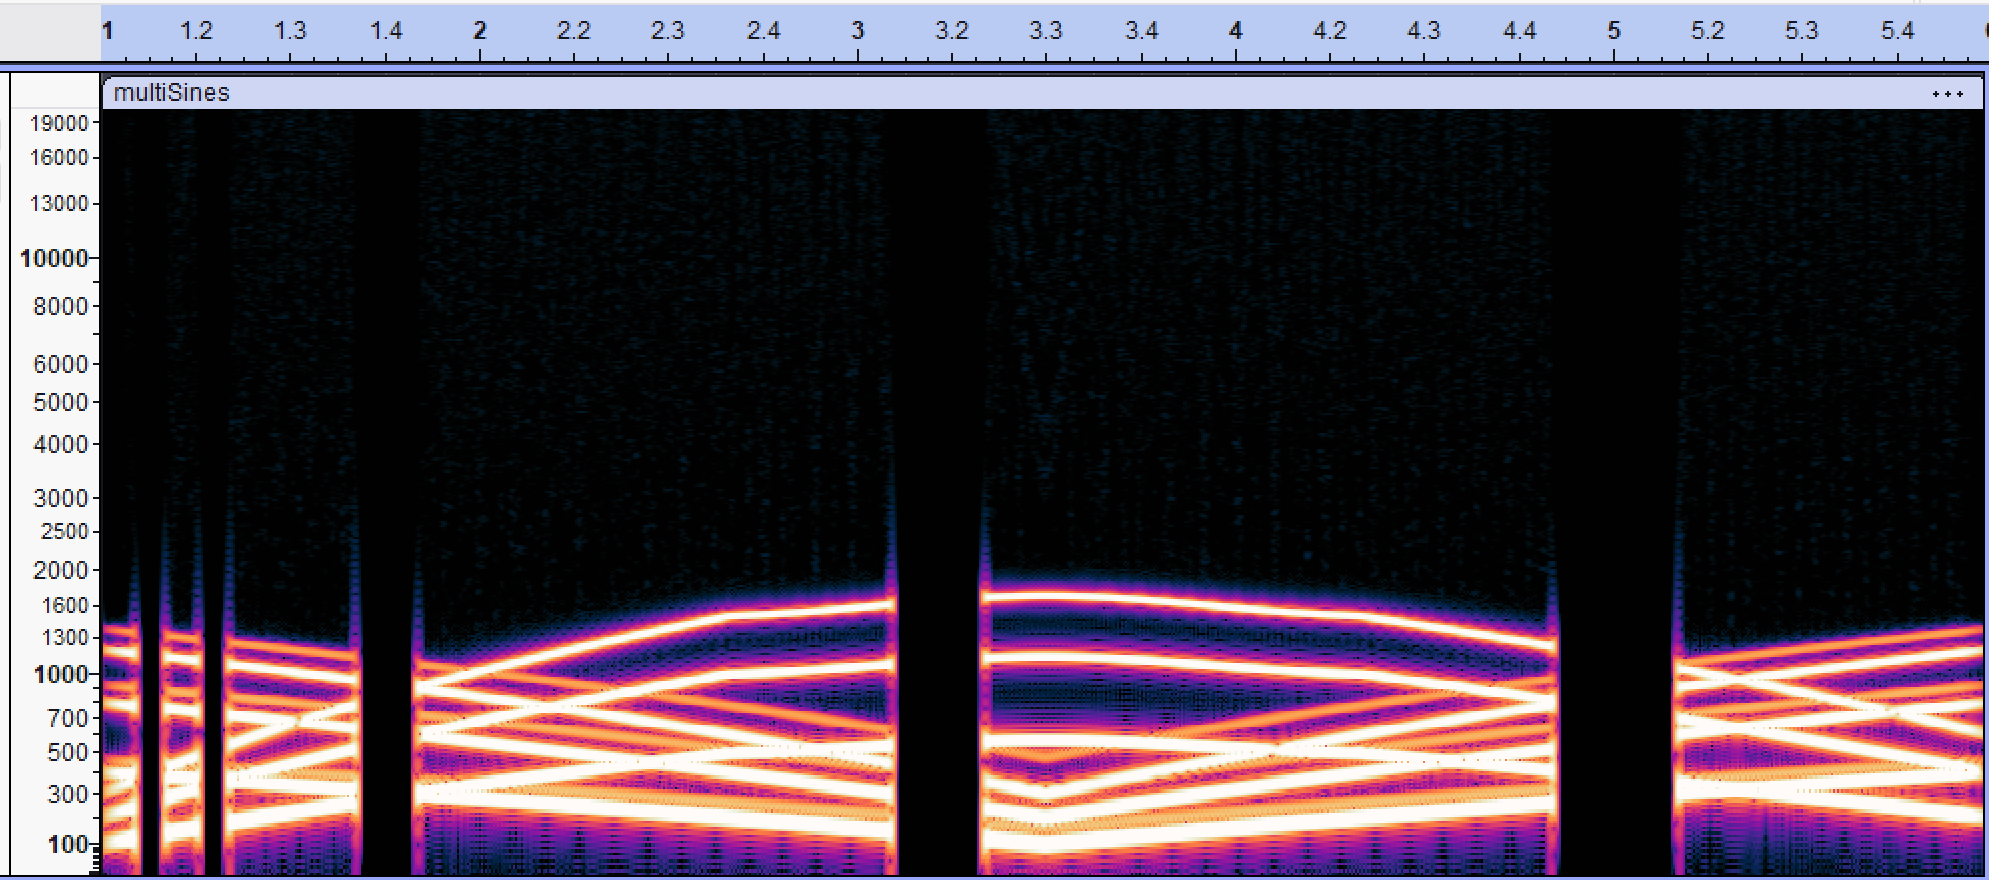


**Spectrum**


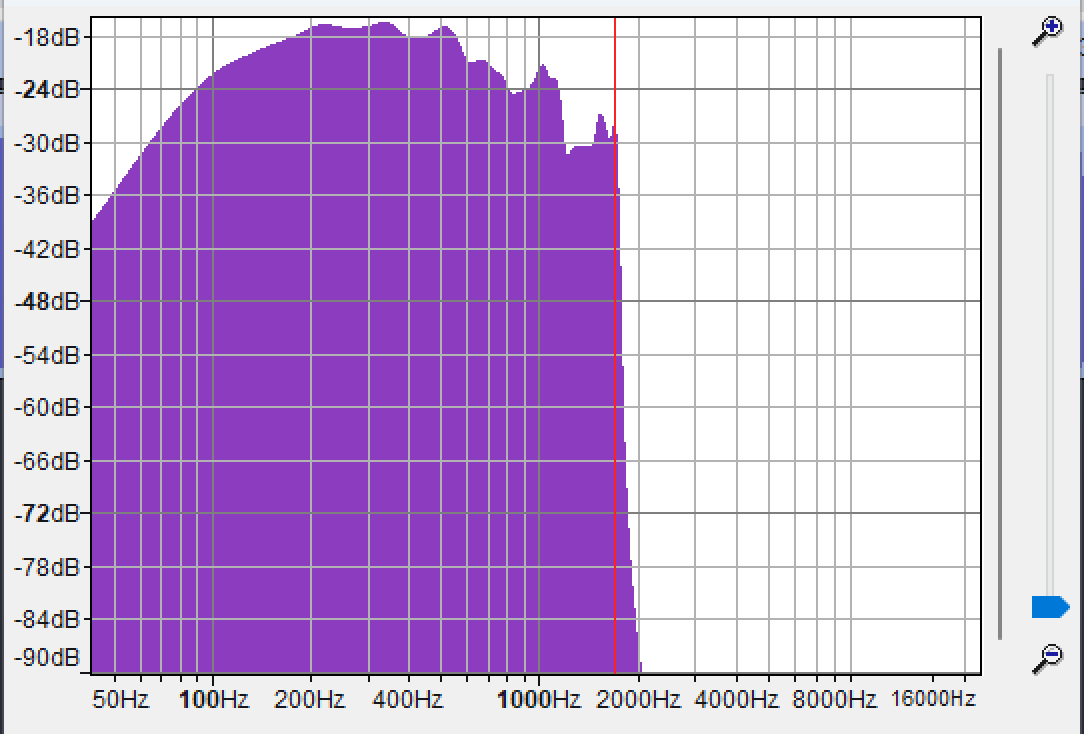

 
After examining the spectogram and spectrum of the sound, as well of listening it we can determine that the input sound contains fast transitions, closely spaced frequency components, a wide range of amplitudes, and time-varying chirps. These characteristics make it challenging for sinusoidal modeling, which typically assumes smoother transitions. To ensure an accurate representation, the analysis parameters must be carefully selected.

The window length, M, is set to 2248 to balance time and frequency resolution. This value was determined using the formula seen in class, since we are using a hamming window we know that B s≈2.5 and we assume a frequency difference of 50Hz, then we know that M must be bigger than 2205. A smaller M, such as 512 or 1024, would improve time resolution, making it better for tracking fast transitions but at the cost of poor frequency resolution. Conversely, a larger M, like 4096, would improve frequency resolution, helping to distinguish closely spaced frequencies but reducing the ability to capture transients. Choosing M = 2248 provides a suitable compromise, allowing for the resolution of closely spaced sinusoids while still maintaining a reasonable response to time variations.

A Hamming window is used because it offers good frequency resolution while reducing spectral leakage, which is important for accurately tracking frequency components without introducing excessive artifacts. The FFT size, N, is set to 4096, since it needs to be bigger or equal to the M and a power of 2 for computational efficiency. 

The threshold for peak detection is set to -80 dB to ensure that weaker partials are detected without introducing excessive noise. If the threshold were too high, some quieter components might be missed, reducing the accuracy of the sinusoidal model.

Since the sound contains a rich harmonic spectrum, the maximum number of sinusoids is set to 40 to capture all significant spectral components. Additionally, the minimum sine duration is set to 0.05 seconds as we can see in the spectogram there are partials of short duration (not smaller than 0.05 seconds), this way, choosing a smaller minimum duration ensures that they are tracked properly without filtering out meaningful components.

The chosen parameters result in an almost perfect time-domain reconstruction, as observed in the output sound. There are no perceptible differences to the ear, and the spectrogram of the sinusoidal model closely matches the one of the original signal.


**Spectogram of the modeled sinus**

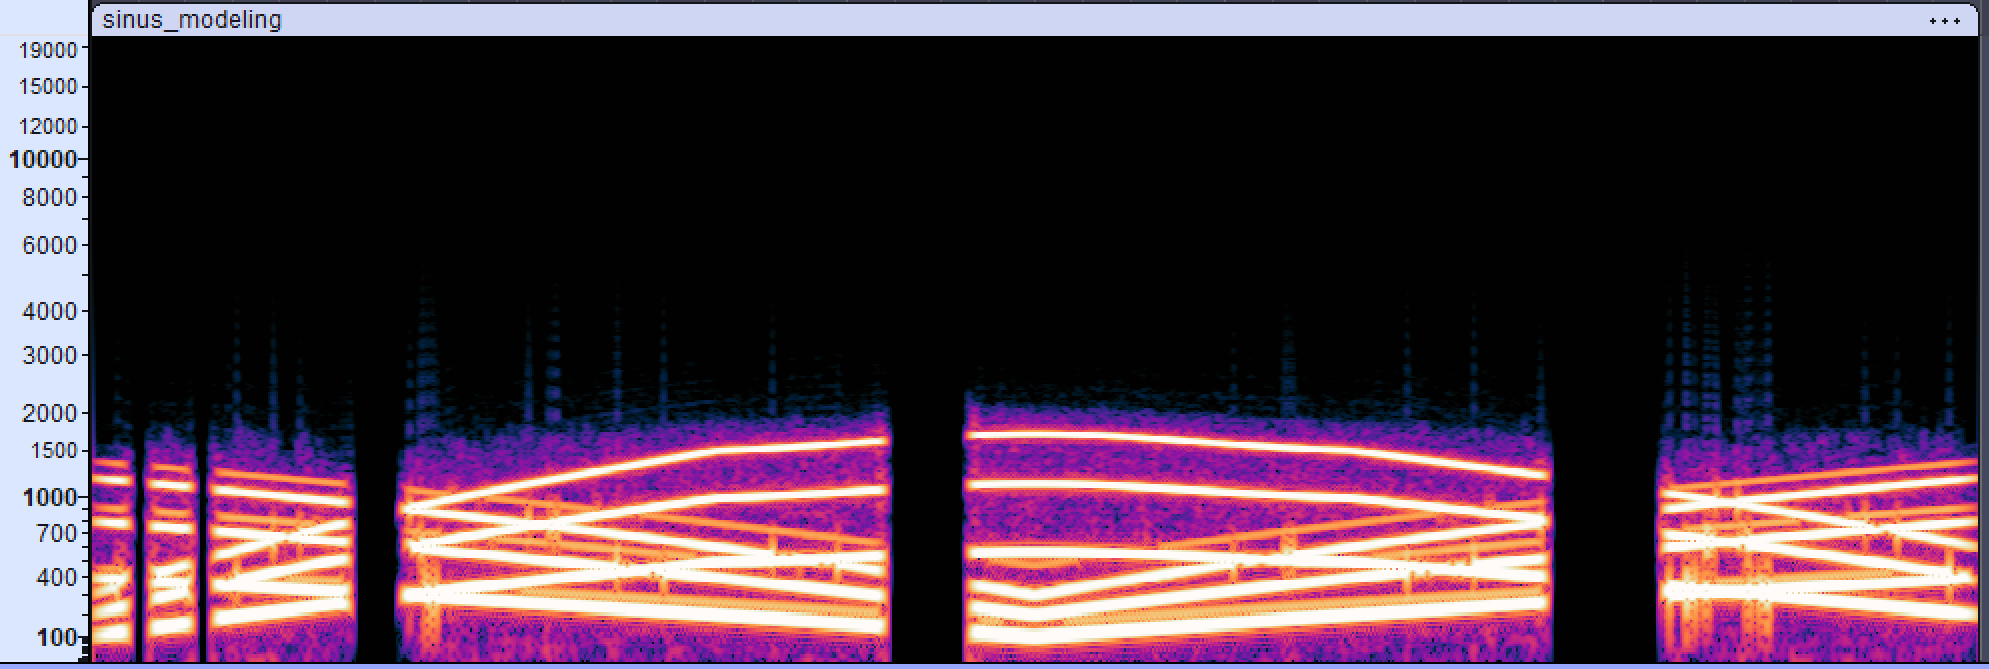